# MNIST

In [1]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## MLP

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Dataset Loading and EDA

In [3]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Count unique training dataset label
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

# Count unique test dataset label
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels: ", dict(zip(unique, counts)))

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [4]:
# Extract Training Dataset Randomly
indexes = np.random.randint(0, x_train.shape[0], size=9)
images = x_train[indexes]
labels = y_train[indexes]

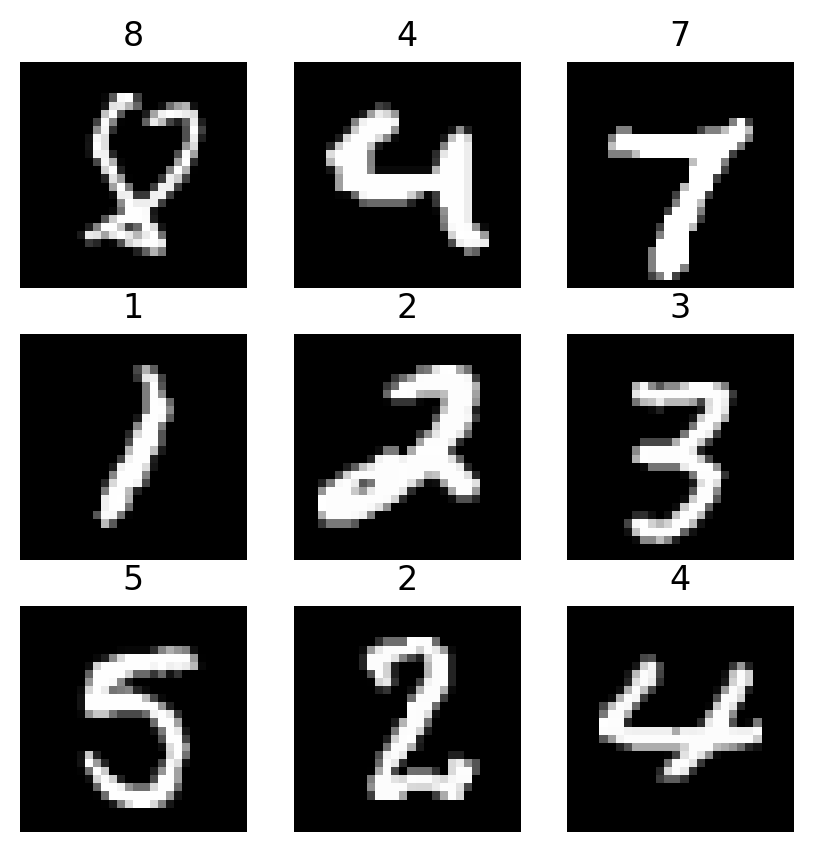

In [5]:
# Draw 9 MNIST dataset
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(3,3, i+1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(y_train[indexes[i]])
plt.show()

### Preprocessing

In [6]:
from keras.layers import Flatten, Dense, Dropout

In [7]:
# Count the number of labels
num_labels = len(np.unique(y_train))

# One-Hot Encoding
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

# Image Dimension
image_size = x_train.shape[1] # (60000, 28, 28)
input_size = (image_size, image_size)

# Normalize
x_train = x_train.astype('float32')/255 # Normalize
x_test = x_test.astype('float32')/255 # Normalize

# NN Parameters
batch_size = 128
hidden_units = 256
dropout = .45

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=100000).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

Metal device set to: Apple M2


2023-01-29 17:14:59.225040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-29 17:14:59.225124: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Feature batch shape: (64, 28, 28)
Labels batch shape: (64, 10)


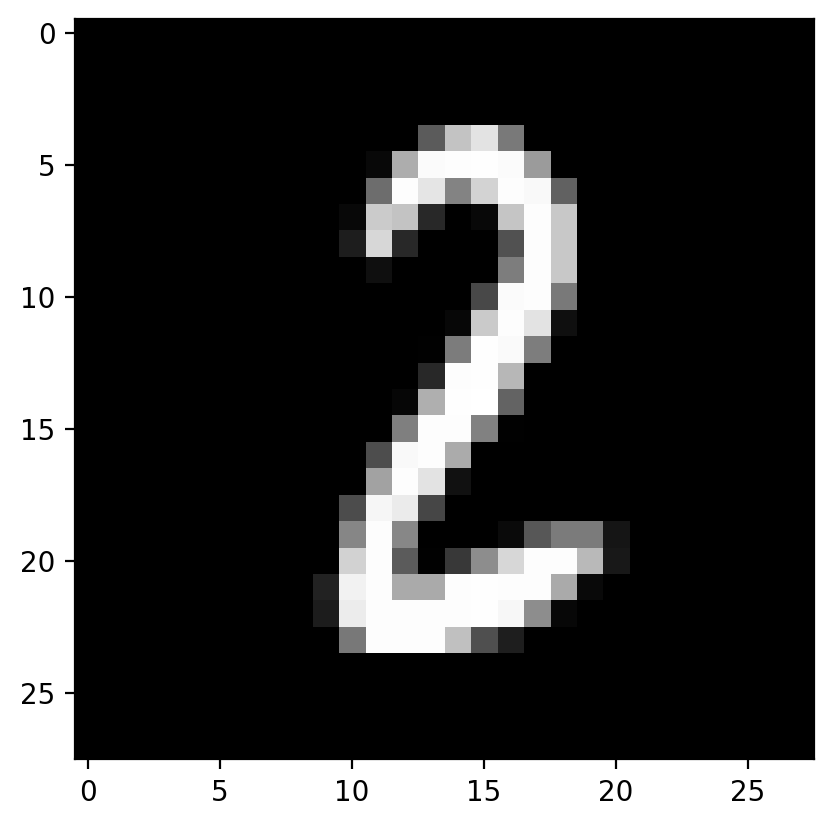

Label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
imgs, lbs = next(iter(train_dataset))
print(f"Feature batch shape: {imgs.shape}")
print(f"Labels batch shape: {lbs.shape}")

img = imgs[0]
lb = lbs[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {lb}")

### Modeling
- Build-up Sequential API Model
- Layers: 256-256-256
- Regularizer: Dropdout(.45)
- Optimizer: Adam

In [10]:
def create_seq_model():
    model = keras.Sequential()
    model.add(Flatten(input_shape = input_size))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_labels, activation='softmax'))
    return model

seq_model = create_seq_model()
seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trai

In [11]:
def create_func_model():
    inputs = keras.Input(shape = input_size)
    flatten = keras.layers.Flatten()(inputs)
    dense1 = keras.layers.Dense(hidden_units, activation='relu')(flatten)
    drop1 = keras.layers.Dropout(dropout)(dense1)
    dense2 = keras.layers.Dense(hidden_units, activation='relu')(drop1)
    drop2 = keras.layers.Dropout(dropout)(dense2)
    outputs = keras.layers.Dense(num_labels, activation='softmax')(drop2)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

func_model = create_func_model()
func_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                2570  

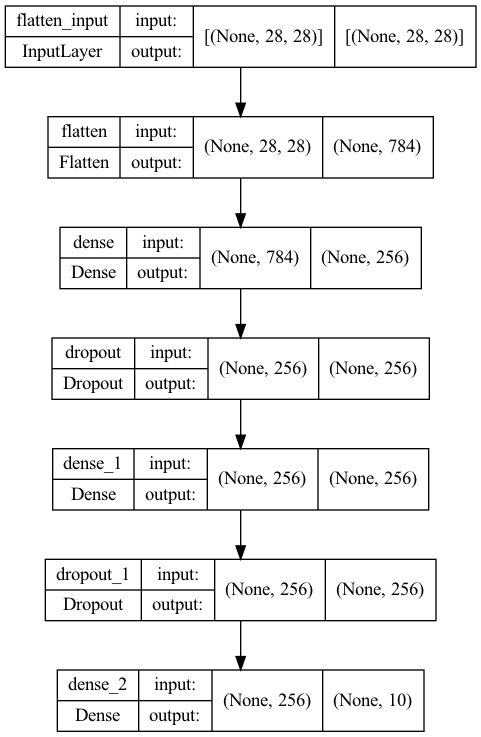

In [12]:
keras.utils.plot_model(seq_model, to_file='mlp-mnist.png', show_shapes=True)

In [13]:
learning_rate=0.001
seq_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy']
                 )

In [14]:
history = seq_model.fit(train_dataset,
                        epochs=20,
                        batch_size=batch_size,
                        validation_data=test_dataset)

Epoch 1/20
  7/938 [..............................] - ETA: 8s - loss: 2.1438 - accuracy: 0.2210  

2023-01-29 17:14:59.996463: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-29 17:14:59.996531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.8982

2023-01-29 17:15:06.480502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 7s 8ms/step - loss: 0.3326 - accuracy: 0.8982 - val_loss: 0.1292 - val_accuracy: 0.9601
Epoch 2/20
938/938 [==============================] - 7s 7ms/step - loss: 0.1605 - accuracy: 0.9519 - val_loss: 0.0957 - val_accuracy: 0.9719
Epoch 3/20
938/938 [==============================] - 7s 7ms/step - loss: 0.1270 - accuracy: 0.9613 - val_loss: 0.0792 - val_accuracy: 0.9754
Epoch 4/20
938/938 [==============================] - 7s 7ms/step - loss: 0.1067 - accuracy: 0.9670 - val_loss: 0.0866 - val_accuracy: 0.9747
Epoch 5/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0915 - accuracy: 0.9711 - val_loss: 0.0803 - val_accuracy: 0.9766
Epoch 6/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0842 - accuracy: 0.9738 - val_loss: 0.0740 - val_accuracy: 0.9784
Epoch 7/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0781 - accuracy: 0.9755 - val_loss: 0.0683 - val_accuracy: 0.9783
Epoch 8/20
938/93

In [15]:
loss, acc = seq_model.evaluate(test_dataset, batch_size=batch_size)
print(f"Test accuracy: {(100*acc):>.1f}%")

157/157 [==============================] - 1s 5ms/step - loss: 0.0684 - accuracy: 0.9830
Test accuracy: 98.3%


### Visualization

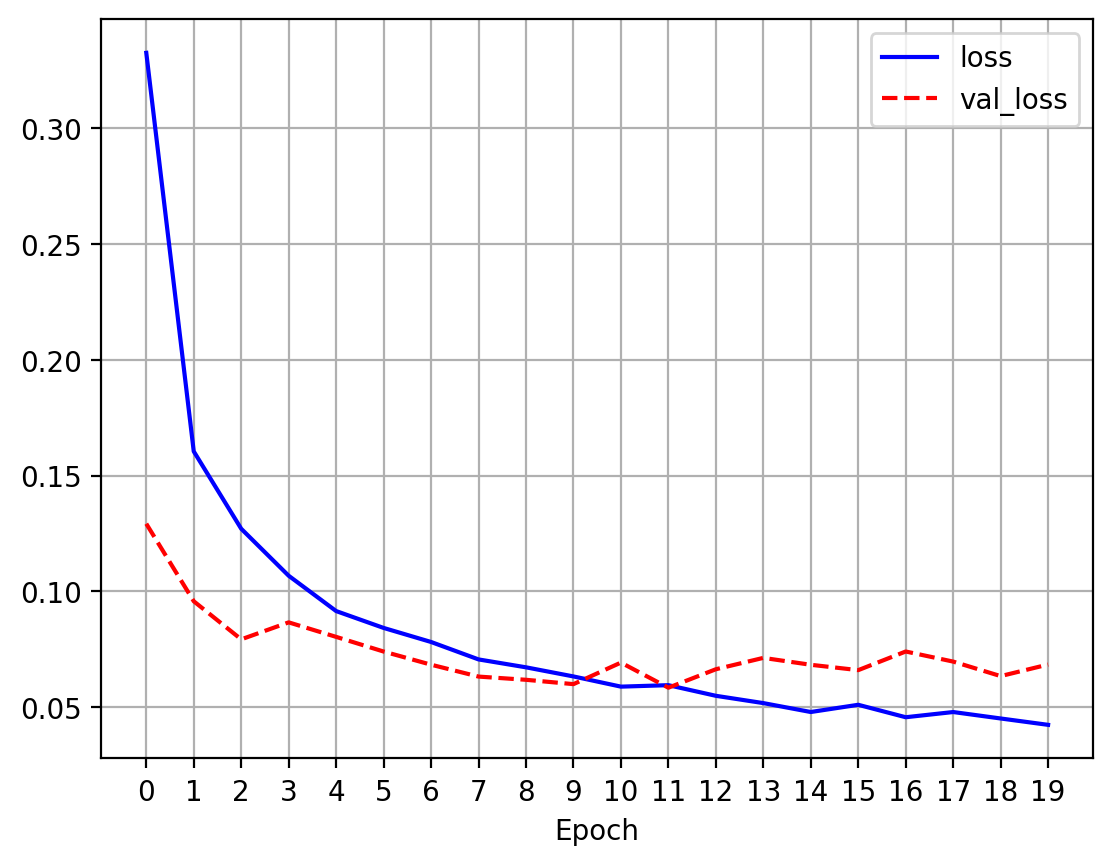

In [28]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.xticks(range(0,20))
plt.grid()
plt.legend()
plt.show()

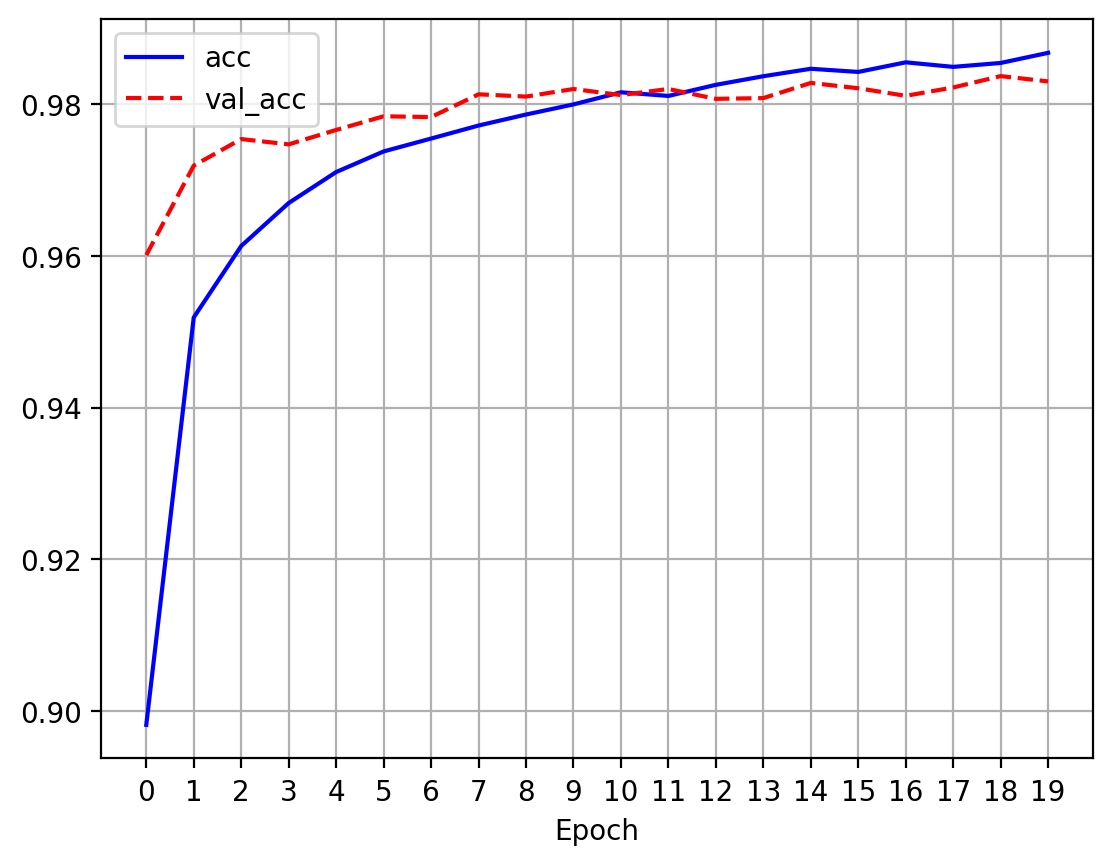

In [29]:
plt.plot(history.history['accuracy'], 'b-', label='acc')
plt.plot(history.history['val_accuracy'], 'r--', label='val_acc')
plt.xlabel('Epoch')
plt.xticks(range(20))
plt.grid()
plt.legend()
plt.show()

### Tensorboard

In [30]:
%load_ext tensorboard